<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Kaggle/Facial_Keypoint_Detection/Facial_Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
!kaggle competitions download -c facial-keypoints-detection

 31% 5.00M/16.0M [00:00<00:01, 11.3MB/s]
100% 16.0M/16.0M [00:00<00:00, 29.7MB/s]
 75% 45.0M/60.1M [00:01<00:00, 16.2MB/s]
100% 60.1M/60.1M [00:01<00:00, 43.0MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 64.8MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 46.3MB/s]


In [6]:
IdLookupTable = pd.read_csv('IdLookupTable.csv')

In [7]:
IdLookupTable

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [8]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [9]:
!unzip ../content/training.zip
!unzip ../content/test.zip

Archive:  ../content/training.zip
  inflating: training.csv            
Archive:  ../content/test.zip
  inflating: test.csv                


In [10]:
training_pd = pd.read_csv('training.csv')
test_pd = pd.read_csv('test.csv')

In [ ]:
training_pd.head()

In [12]:
training_pd.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [13]:
training_pd = training_pd.fillna(method='ffill')

In [14]:
training = training_pd.to_numpy()
test = test_pd.to_numpy()

In [15]:
print(training.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [16]:
train_image = training[:, -1]
train_key = training[:, :-1].astype('float64')
test_image = test[:, 1]
print(train_image.shape)
print(train_key.shape)
print(test_image.shape)

(7049,)
(7049, 30)
(1783,)


In [17]:
train_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in train_image])
test_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in test_image])

In [18]:
print(train_image.shape)
print(test_image.shape)

(7049, 96, 96)
(1783, 96, 96)


In [19]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# from 'Facial Keypoint Detection - CNN + Augmentation' by Luong Quang Dung

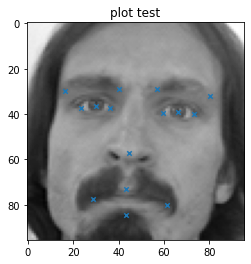

In [20]:
fig, axis = plt.subplots()
plot_sample(train_image[0], train_key[0], axis, 'plot test')

In [21]:
EPOCHS = 10
BATCH_SIZE = 32

In [22]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device:  cuda


In [23]:
class FaceDataset(Dataset):

    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')
        self.y_data = torch.from_numpy(y).type('torch.FloatTensor')

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = FaceDataset(train_image, train_key)
print(len(dataset))

7049


In [24]:
lengths = [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
print(lengths)
train_data, val_data = torch.utils.data.random_split(dataset, lengths)
print(len(train_data))

[5639, 1410]
5639


In [25]:
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [26]:
for (x_train, y_train) in train_loader:
  print("x_train:", x_train.size(), 'type:', x_train.type())
  print("y_train:", y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 96, 96]) type: torch.FloatTensor
y_train: torch.Size([32, 30]) type: torch.FloatTensor


In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(96 * 96, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 30)
    
    def forward(self, x):
        x = x.view(-1, 96 * 96)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x, dim = 1)
        return x


In [28]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [44]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = RMSELoss()

print(model)

Net(
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=30, bias=True)
)


In [30]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, key) in enumerate(train_loader):
        image = image.to(DEVICE)
        key = key.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, key)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


In [31]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, key in val_loader:
            image = image.to(DEVICE)
            key = key.to(DEVICE)
            output = model(image)
            val_loss += criterion(output, key).item()

    val_loss /= len(val_loader.dataset)
    val_loss *= BATCH_SIZE
    return val_loss

In [32]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss = evaluate(model, val_loader)
    print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
          format(Epoch, val_loss))


Train Epoch: 1 [0/5639(0%)]	Train Loss: 51.640652
Train Epoch: 1 [640/5639(11%)]	Train Loss: 15.177410
Train Epoch: 1 [1280/5639(23%)]	Train Loss: 13.144023
Train Epoch: 1 [1920/5639(34%)]	Train Loss: 11.325653
Train Epoch: 1 [2560/5639(45%)]	Train Loss: 8.887866
Train Epoch: 1 [3200/5639(56%)]	Train Loss: 11.167423
Train Epoch: 1 [3840/5639(68%)]	Train Loss: 10.902946
Train Epoch: 1 [4480/5639(79%)]	Train Loss: 11.815574
Train Epoch: 1 [5120/5639(90%)]	Train Loss: 12.770579

[EPOCH: 1], 	Val Loss: 13.1055

Train Epoch: 2 [0/5639(0%)]	Train Loss: 12.771726
Train Epoch: 2 [640/5639(11%)]	Train Loss: 12.705249
Train Epoch: 2 [1280/5639(23%)]	Train Loss: 8.389673
Train Epoch: 2 [1920/5639(34%)]	Train Loss: 10.130980
Train Epoch: 2 [2560/5639(45%)]	Train Loss: 11.288897
Train Epoch: 2 [3200/5639(56%)]	Train Loss: 11.389457
Train Epoch: 2 [3840/5639(68%)]	Train Loss: 9.714561
Train Epoch: 2 [4480/5639(79%)]	Train Loss: 10.834352
Train Epoch: 2 [5120/5639(90%)]	Train Loss: 10.870229

[EPOCH:

In [33]:
def predict(val_data, idx, plot=False):
    image_pred = val_data[idx][0].to(DEVICE)
    with torch.no_grad():
        prediction = model(image_pred)
    
    image_pred = image_pred.cpu().numpy()*255.
    prediction = prediction.cpu().numpy().reshape(30)
    answer = val_data[idx][1]

    if plot == True:
        fig, axis = plt.subplots()
        prediction_plot(image_pred, prediction, answer, axis, 'prediction plot for {}th image in val_data'.
                        format(idx))


In [34]:
def prediction_plot(image, keypoint, answer, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    axis.scatter(answer[0::2], answer[1::2], marker='x', color='r', s=20)
    plt.title(title)


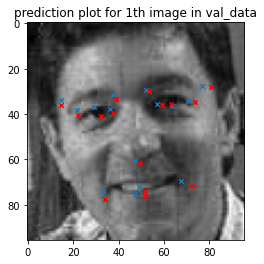

In [35]:
predict(val_data, 1, True)

In [36]:
EPOCHS = 60
BATCH_SIZE = 32

In [37]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 3,
            kernel_size = 3,
            padding = 1)
        self.conv2 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1)
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2)
        self.fc1 = nn.Linear(24 * 24 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 30)
    
    def forward(self, x):
        x = x.view(-1, 1, 96, 96)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 24 * 24 * 8)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [51]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = RMSELoss()

print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=30, bias=True)
)


In [39]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 120)
    val_loss = evaluate(model, val_loader)
    print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
          format(Epoch, val_loss))


Train Epoch: 1 [0/5639(0%)]	Train Loss: 51.663666


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [3840/5639(68%)]	Train Loss: 3.653306

[EPOCH: 1], 	Val Loss: 3.1568

Train Epoch: 2 [0/5639(0%)]	Train Loss: 3.513086
Train Epoch: 2 [3840/5639(68%)]	Train Loss: 2.841172

[EPOCH: 2], 	Val Loss: 3.1732

Train Epoch: 3 [0/5639(0%)]	Train Loss: 2.706816
Train Epoch: 3 [3840/5639(68%)]	Train Loss: 3.313781

[EPOCH: 3], 	Val Loss: 3.1442

Train Epoch: 4 [0/5639(0%)]	Train Loss: 3.727566
Train Epoch: 4 [3840/5639(68%)]	Train Loss: 3.546583

[EPOCH: 4], 	Val Loss: 3.4633

Train Epoch: 5 [0/5639(0%)]	Train Loss: 3.001446
Train Epoch: 5 [3840/5639(68%)]	Train Loss: 3.727321

[EPOCH: 5], 	Val Loss: 4.1341

Train Epoch: 6 [0/5639(0%)]	Train Loss: 4.176545
Train Epoch: 6 [3840/5639(68%)]	Train Loss: 2.916804

[EPOCH: 6], 	Val Loss: 3.0789

Train Epoch: 7 [0/5639(0%)]	Train Loss: 3.410574
Train Epoch: 7 [3840/5639(68%)]	Train Loss: 3.523002

[EPOCH: 7], 	Val Loss: 3.1695

Train Epoch: 8 [0/5639(0%)]	Train Loss: 3.526429
Train Epoch: 8 [3840/5639(68%)]	Train Loss: 2.835268

[EPOCH: 

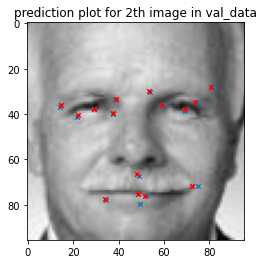

In [40]:
predict(val_data, 2, True)

모델 저장 및 불러오기는 
https://justkode.kr/deep-learning/pytorch-save
https://honeyjamtech.tistory.com/39
**참고해서** 다시 정리하기

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
PATH = '/content/drive/MyDrive/Colab Notebooks/FKD_model'

torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')

In [45]:
model = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수, parameter값도 같이 불러옴
# 위에서 클래스 선언 필수라는 말은, 모델의 클래스가 선언되어야 한다는 뜻
print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=30, bias=True)
)


In [ ]:
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장
model.state_dict()

In [ ]:
checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
checkpoint['optimizer']  # optimizer.sate_dict()는 

In [52]:
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
optimizer.state_dict()

Ray Tune 사용해보기 --> CNN 모델에서 가장 좋은 hyperparamter 찾고 Kaggle에 답안 제출해보기
https://tutorials.pytorch.kr/beginner/hyperparameter_tuning_tutorial.html